# TDT13 Project - Oskar Holm (F2023)

This project is based on the shared task related to Social Media Geolocation (SMG) from VarDial 2020 and 2021, specifically the Workshop on Natural Language Processing (NLP) for Similar Languages, Varieties, and Dialects. Unlike typical VarDial tasks that involve choosing from a set of variety labels, this task focuses on predicting the latitude and longitude from which a social media post was made.

The task remained the same in both 2020 and 2021, covering three language areas: Bosnian-Croatian-Montenegrin-Serbian, German (Germany and Austria), and German-speaking Switzerland. This project is limited to the German-speaking Switzerland area due to time constraints and resource availability.

The goal of the project is to replicate the results of a study that used a BERT-based classifier for this double regression task. The dataset from the 2020 VarDial challenge is chosen because it had more submissions compared to the 2021 dataset. 

## Dependencies and Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json 
from transformers import AutoModelForSequenceClassification, AdamW
from torch.nn import L1Loss
from tqdm import tqdm

from lib.scalers import scalers
from lib.train_utils import TensorBoardCheckpoint
from lib.geo_utils import mean_distance, median_distance, to_projection, GeolocationDataset

## Load Config and Datasets

In [3]:
config_name = 'utm_lr2e-5'
with open('./configs.json', 'r') as f: 
    config = json.load(f)[config_name]

config

{'train_data': 'SMG2020/ch/train.txt',
 'dev_data': 'SMG2020/ch/dev.txt',
 'scaler': 'joint',
 'model_type': 'bert',
 'model_name': 'statworx/bert-base-german-cased-finetuned-swiss',
 'lossfn': 'MAELoss',
 'save_predictions': True,
 'train_batch_size': 32,
 'max_seq_length': 128,
 'epochs': 50,
 'lr': 2e-05,
 'seed': 42,
 'projection': 'utm',
 'zone_number': 32,
 'zone_letter': 'T'}

In [4]:
train_data = pd.read_table('vardial-shared-tasks/SMG2020/ch/train.txt', header=None, names=['lat', 'lon', 'text'])
dev_data = pd.read_table('vardial-shared-tasks/SMG2020/ch/dev.txt', header=None, names=['lat', 'lon', 'text'])
test_gold_data = pd.read_table('vardial-shared-tasks/SMG2020/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])

train_data, col_names = to_projection(train_data, config)
dev_data, _ = to_projection(dev_data, config)
test_gold_data, _ = to_projection(test_gold_data, config)

scaler = scalers[config['scaler']]()

train_coords = scaler.fit_transform(train_data[col_names[:2]].values)
train_dataset = GeolocationDataset(train_data['text'].tolist(), train_coords, config)
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)

Path('data/ch').mkdir(exist_ok=True)
with open('data/ch/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

dev_coords = scaler.transform(dev_data[col_names[:2]].values)
dev_dataset = GeolocationDataset(dev_data['text'].tolist(), dev_coords, config)
dev_loader = DataLoader(dev_dataset, batch_size=config['train_batch_size'], shuffle=False)

test_gold_coords = scaler.transform(test_gold_data[col_names[:2]].values)
test_gold_dataset = GeolocationDataset(test_gold_data['text'].tolist(), test_gold_coords, config)
test_gold_loader = DataLoader(test_gold_dataset, batch_size=config['train_batch_size'], shuffle=False)

In [5]:
test_gold_data

,easting,northing,text
0,458397.093648,5.235316e+06,Wie chan ich uf en channel zuegriffe? Mussi da...
1,424486.894464,5.245656e+06,Es esch jo scho witzig zue zluege wie d Eltere...
2,454734.841764,5.250902e+06,wie öberläbe das d pendler jede tag? #respekt ...
3,543374.940570,5.199765e+06,Ganz a saftigi Präsentation gsi 😂 Alles werden...
4,464737.370193,5.283064e+06,Wieso me Omis immer mit Chinderwäge gseht? Isc...
...,...,...,...
3092,458561.939246,5.258654e+06,Du weisch es isch no zfrüeh am morge wenn der ...
3093,480303.537428,5.226311e+06,V' bisches du @1 nei ich bin P Abr wibmich hah...
3094,459261.345896,5.250869e+06,bin gester vo dihei uszoge und han mit schreck...
3095,481171.647650,5.260760e+06,Massekontrolle in Stadt Winterthur 🤷🏼‍♀️😌 Tell...


## Training and Evaluation

### Load Model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
torch.cuda.empty_cache()

model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=2)
optimizer = AdamW(model.parameters(), config['lr'])
model.to(device)

Device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\koholm\dev\TDT13\venv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Training Loop

In [8]:
def evaluate_geolocation_model(test_gold_loader, test_gold_coords, scaler, config, model, device):
    with torch.no_grad():
        test_preds = []
        for batch in tqdm(test_gold_loader):
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            test_preds.append(logits.cpu().numpy())

    test_preds = np.concatenate(test_preds, axis=0)

    results = {
        'median_distance': median_distance(test_gold_coords, test_preds, scaler, config),
        'mean_distance': mean_distance(test_gold_coords, test_preds, scaler, config)
    }

    print(f'Test results: {results}\n')

    return results['median_distance'], results['mean_distance']

In [ ]:
loss_function = L1Loss()

tb_checkpoint = TensorBoardCheckpoint(log_dir='data/ch/logs',
                                      checkpoint_path='data/ch/checkpoints', run_name=config_name)

def train(model, train_loader, dev_loader, optimizer, loss_function, scaler, epochs=10):
    loss_function = loss_function.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            # Forward pass
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)

            # Calculate loss
            loss = loss_function(outputs.logits, labels)
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Training loss: {avg_train_loss:.4f}")

        # Evaluate on dev (validation)
        model.eval()
        dev_preds = []
        dev_labels = []
        with torch.no_grad():
            for batch in tqdm(dev_loader):
                inputs, labels = batch
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                outputs = model(**inputs)
                dev_preds.append(outputs.logits.cpu().numpy())
                dev_labels.append(labels.cpu().numpy())

        # Metrics
        dev_preds = np.vstack(dev_preds)
        dev_labels = np.vstack(dev_labels)

        median_dist = median_distance(dev_preds, dev_labels, scaler, config)
        mean_dist = mean_distance(dev_preds, dev_labels, scaler, config)

        median_dist_test, mean_dist_test = evaluate_geolocation_model(test_gold_loader, test_gold_coords, scaler, config, model, device)

        metrics = {
            'Loss/train': avg_train_loss, 
            'Median_Distance/dev': median_dist, 
            'Mean_Distance/dev': mean_dist,
            'Median_Distance/test': median_dist_test, 
            'Mean_Distance/test': mean_dist_test,
        }
        tb_checkpoint.log_metrics(metrics, epoch)
        tb_checkpoint.save_checkpoint(model, optimizer, epoch, metrics, scaler)

with open('data/ch/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

train(model, train_loader, dev_loader, optimizer, loss_function, scaler, epochs=config['epochs'])

tb_checkpoint.close()

### Model Evaluation

In [62]:
def evaluate_geolocation_model_by_checkpoint(checkpoint_dir, checkpoint_file, config, model, device):
    torch.cuda.empty_cache()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=2)
    model.to(device)
    
    checkpoint_path = f'{checkpoint_dir}/{checkpoint_file}'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(checkpoint['metrics'])

    train_data = pd.read_table('vardial-shared-tasks/SMG2020/ch/train.txt', header=None, names=['lat', 'lon', 'text'])
    train_data, col_names = to_projection(train_data, config)

    scaler_name = config['scaler']
    checkpoint_scaler = scalers[scaler_name]()
    checkpoint_scaler.fit(train_data[col_names[:2]].values)

    test_gold_data = pd.read_table('vardial-shared-tasks/SMG2020/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])
    test_gold_data, _ = to_projection(test_gold_data, config)
    test_gold_coords = checkpoint_scaler.transform(test_gold_data[col_names[:2]].values)
    test_gold_dataset = GeolocationDataset(test_gold_data['text'].tolist(), test_gold_coords, config)
    test_gold_loader = DataLoader(test_gold_dataset, batch_size=config['train_batch_size'], shuffle=False)

    model.eval()

    with torch.no_grad():
        test_preds = []
        for batch in tqdm(test_gold_loader):
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            test_preds.append(logits.cpu().numpy())

    test_preds = np.concatenate(test_preds, axis=0)

    results = {
        'median_distance': median_distance(test_gold_coords, test_preds, checkpoint_scaler, config),
        'mean_distance': mean_distance(test_gold_coords, test_preds, checkpoint_scaler, config)
    }

    print(f'{checkpoint_file} test results: {results}\n')

    return results, checkpoint_scaler.inverse_transform(test_preds)

In [42]:
chkp_dir = 'data/ch/checkpoints'

with open('./configs.json', 'r') as f:
    configs = json.load(f)

config_names = configs.keys()

best_results = {
    'median_distance': np.inf,
    'mean_distance': np.inf
}

for config_name in config_names:
    chkp_file = f'{config_name}_best_model.pth'
    chkp_config = configs[config_name]

    results, _ = evaluate_geolocation_model_by_checkpoint(
        chkp_dir,
        chkp_file,
        chkp_config,
        model,
        device
    )

    if results['median_distance'] < best_results['median_distance']:
        best_checkpoint = chkp_file
        best_results['median_distance'] = results['median_distance']
        best_results['mean_distance'] = results['mean_distance']

print("\nBest Checkpoint:", best_checkpoint)
print("Best Results:", best_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.0759011995221213, 'Median_Distance/dev': 16.61938, 'Mean_Distance/dev': 23.569262}


100%|██████████| 97/97 [00:18<00:00,  5.20it/s]


20231107-230346_best_model.pth test results: {'median_distance': 16.44642298143306, 'mean_distance': 23.11484565124471}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.06783869971100984, 'Median_Distance/dev': 16.38829839218065, 'Mean_Distance/dev': 24.333732175908516}


100%|██████████| 97/97 [00:18<00:00,  5.30it/s]


20231108-155200_best_model.pth test results: {'median_distance': 16.570519292930843, 'mean_distance': 23.857210359269036}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.08351008492868388, 'Median_Distance/dev': 17.6073960849464, 'Mean_Distance/dev': 25.83766967792643}


100%|██████████| 97/97 [00:18<00:00,  5.16it/s]


20231110-113013_best_model.pth test results: {'median_distance': 17.805843571177228, 'mean_distance': 25.810173341015037}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.060019772410224145, 'Median_Distance/dev': 17.207807594306956, 'Mean_Distance/dev': 25.37988651722203}


100%|██████████| 97/97 [00:18<00:00,  5.23it/s]


20231110-172533_best_model.pth test results: {'median_distance': 17.07817041664216, 'mean_distance': 24.844411005876797}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.07250768285049744, 'Median_Distance/dev': 16.85694371272279, 'Mean_Distance/dev': 24.466616258311}


100%|██████████| 97/97 [00:18<00:00,  5.17it/s]


20231111-130032_best_model.pth test results: {'median_distance': 16.90102504837839, 'mean_distance': 24.528637937808156}



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.4205844233700376, 'Median_Distance/dev': 10.79200388937316, 'Mean_Distance/dev': 10.79200388937316, 'Median_Distance/test': 7.137880802169722, 'Mean_Distance/test': 7.137880802169722}


100%|██████████| 97/97 [00:18<00:00,  5.21it/s]

utm_lr2e-5_best_model.pth test results: {'median_distance': 7.137880802169722, 'mean_distance': 7.137880802169722}


Best Checkpoint: utm_lr2e-5_best_model.pth
Best Results: {'median_distance': 7.137880802169722, 'mean_distance': 7.137880802169722}


In [10]:
chkp_dir = 'data/ch/checkpoints'

with open('./configs.json', 'r') as f:
    configs = json.load(f)

config_names = configs.keys()

for config_name in config_names:
    chkp_file = f'{config_name}_best_model.pth'
    chkp_config = configs[config_name]

    _, test_preds = evaluate_geolocation_model_by_checkpoint(
        chkp_dir,
        chkp_file,
        chkp_config,
        model,
        device
    )


In [63]:
config_name = '20231107-230346'

chkp_file = f'{config_name}_best_model.pth'
chkp_config = configs[config_name]

_, test_preds = evaluate_geolocation_model_by_checkpoint(
    chkp_dir,
    chkp_file,
    chkp_config,
    model,
    device
)

test_gold_data = pd.read_table('vardial-shared-tasks/SMG2020/ch/test_gold.txt', header=None, names=['lat', 'lon', 'text'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at statworx/bert-base-german-cased-finetuned-swiss and are newly initialized: ['classifier.bias', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'Loss/train': 0.0759011995221213, 'Median_Distance/dev': 16.61938, 'Mean_Distance/dev': 23.569262}


100%|██████████| 97/97 [00:18<00:00,  5.14it/s]

20231107-230346_best_model.pth test results: {'median_distance': 16.44642298143306, 'mean_distance': 23.11484565124471}



In [66]:
test_gold_data

,lat,lon,text
0,47.27,8.45,Wie chan ich uf en channel zuegriffe? Mussi da...
1,47.36,8.00,Es esch jo scho witzig zue zluege wie d Eltere...
2,47.41,8.40,wie öberläbe das d pendler jede tag? #respekt ...
3,46.95,9.57,Ganz a saftigi Präsentation gsi 😂 Alles werden...
4,47.70,8.53,Wieso me Omis immer mit Chinderwäge gseht? Isc...
...,...,...,...
3092,47.48,8.45,Du weisch es isch no zfrüeh am morge wenn der ...
3093,47.19,8.74,V' bisches du @1 nei ich bin P Abr wibmich hah...
3094,47.41,8.46,bin gester vo dihei uszoge und han mit schreck...
3095,47.50,8.75,Massekontrolle in Stadt Winterthur 🤷🏼‍♀️😌 Tell...


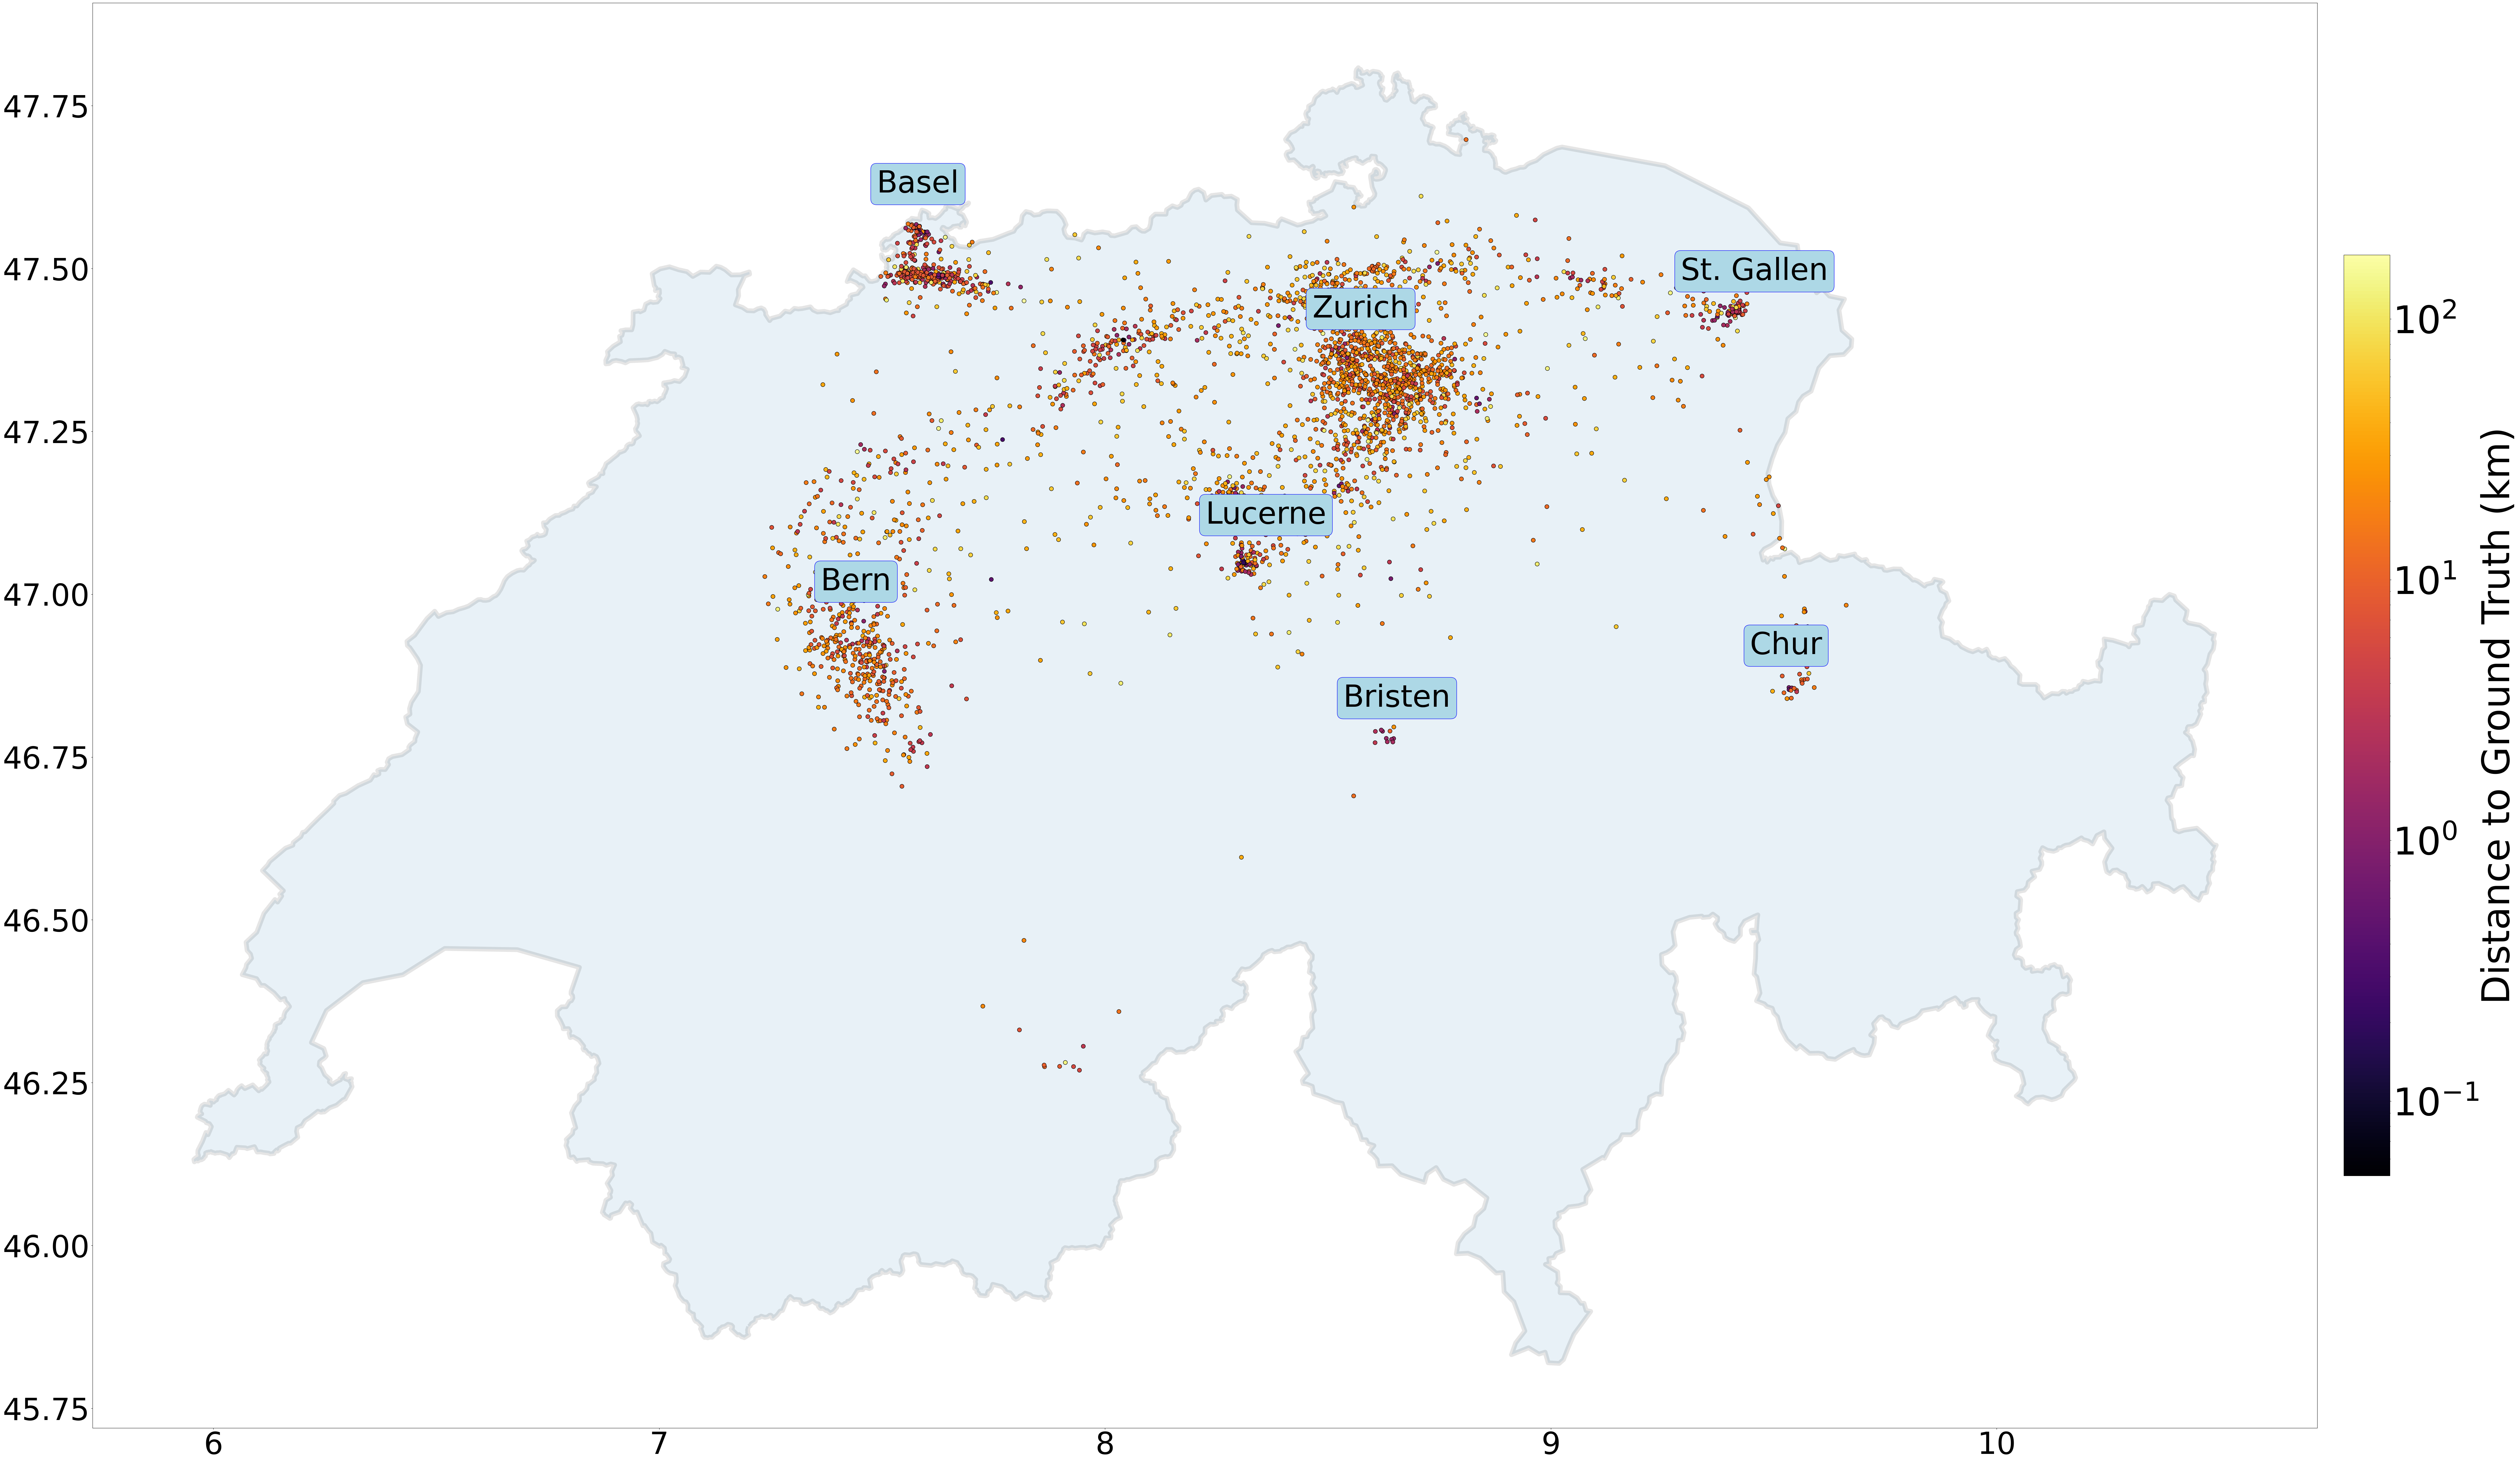

In [175]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.colors import Normalize, LogNorm
from lib.geo_utils import haversine_distance

city_gdf = gpd.read_file('data/swiss_cities.csv', index=False)
city_gdf['geometry'] = [Point(lon, lat) for lon, lat in zip(city_gdf['lon'], city_gdf['lat'])]

switzerland_polygon = gpd.read_file('data/switzerland.geojson')

predicted_points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in test_preds])
predicted_points['distance'] = haversine_distance(test_preds, test_gold_data[['lat', 'lon']].to_numpy())

fig_dim_size = 120
font_size = fig_dim_size * 0.8
ax = switzerland_polygon.plot(figsize=(fig_dim_size, fig_dim_size), alpha=0.1, edgecolor='k', linewidth=fig_dim_size * 0.1)

norm = LogNorm(vmin=predicted_points['distance'].min(), vmax=predicted_points['distance'].max())
sc = ax.scatter(predicted_points.geometry.x, predicted_points.geometry.y, c=predicted_points['distance'], 
                cmap='inferno', s=fig_dim_size * 0.9, marker='o', edgecolors='k', norm=norm)

# city_gdf.plot(ax=ax, markersize=fig_dim_size * 30, color='red', alpha=0.3, marker='o', label='Cities')
for x, y, label in zip(city_gdf.geometry.x, city_gdf.geometry.y, city_gdf['city']):
     ax.annotate(label, xy=(x, y), xytext=(-font_size, font_size), textcoords='offset points', fontsize=font_size * 0.8,
                bbox=dict(boxstyle='round,pad=0.2', edgecolor='blue', facecolor='lightblue'))

ax.tick_params(axis='both', which='both', labelsize=font_size * 0.8)

cbar = plt.colorbar(sc, ax=ax, label='Distance to Ground Truth (km)', pad=0.01, shrink=0.35)
cbar.ax.tick_params(labelsize=font_size)  
cbar.ax.set_ylabel('Distance to Ground Truth (km)', fontsize=font_size)

plt.show()